### Titanic: Machine Learning from Disaster
- This Titanic dataset is a classic Machine Learning tutorial.
- I will perform data cleaning, EDA, feature engineering and use classifcation models to predict survivors on the Titanic.
- Analysis of this dataset was done during a bootcamp. Improved my original score from 0.65 before bootcamp to  0.79 during bootcamp.
- Credit to [Geoffrey Wong](https://www.kaggle.com/csw4192) for helping me get over the damn hump that is 0.80 prediction score with his 'Survivor Confidence'.

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Input data files are available in the "../input/" directory.
import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings('ignore')

['train.csv', 'gender_submission.csv', 'test.csv']


In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [3]:
print(train.info())
print('#'*30)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
##############################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null obje

- For train and test set, majority of missing data are in 'Age' and 'Cabin'. 
-  'Pclass' and 'Survived' are ordinal features. 'Age' and 'Fare' are continous features. 'Ticket' and 'Cabin' contains alphanumeric values. 'PassengerId' is an index.

In [4]:
# variable for test set 'PassengerId' needed for submission
passengerId = test['PassengerId']

# combine train and test set
titanic = train.append(test, ignore_index=True, sort=False )

# indexes for train and test set for modeling
train_idx = len(train)
test_idx = len(titanic) - len(test)

#### EDA

In [5]:
# stats summary
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


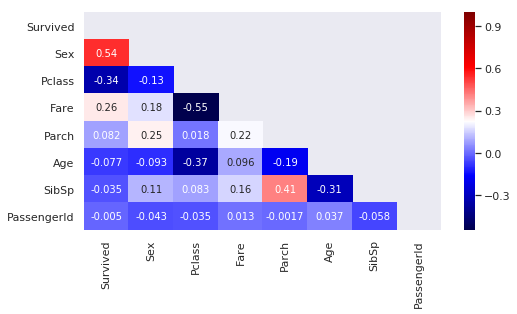

In [6]:
# for correlation heatmap reassign female: 1 and male: 0
train['Sex'] = train['Sex'].map({'female': 1, 'male': 0})

# heatmap correlation to 'Survived'
corr = train.corr()
idx = corr.abs().sort_values(by='Survived', ascending=False).index
corr_idx = train.loc[:,idx]
train_corr = corr_idx.corr()
mask = np.zeros_like(train_corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(8,4))
sns.heatmap(train_corr, mask=mask, annot=True, cmap='seismic')

- The highest numerical correlation is 'Fare,' one can assume that a passenger who bought a more expensive ticket such first class ticket can get to a life boat quicker then a passenger who bought a cheaper ticket, as first class was above deck. 
- Categorical 'Pclass' has a negative correlation meaning that depending on which 'Pclass' a passenger is in, that passenger has a less chance of survival.
- Logically 'Sex' is highest correlated as 'Women and Children first' code have priority evacuation to emergency lifeboats.
- Surprisingly 'Age' correlation to survival is quite low.

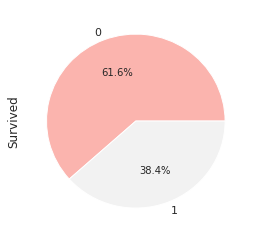

In [7]:
plt.figure(figsize=(4,4))
train['Survived'].value_counts().plot.pie(autopct= '%1.1f%%', cmap='Pastel1')

In [8]:
train['Sex'] = train['Sex'].map({1:'female', 0:'male'})
titanic.groupby(['Pclass', 'Sex'])['Survived'].mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

- In each class, females had the highest percentage of survival.
- 50% of female passengers in third class survived the lowest amount for females.
- 36% of male passengers survived in first class the highest amount for males.
- A total of 38.4% passengers survived from the dataset.

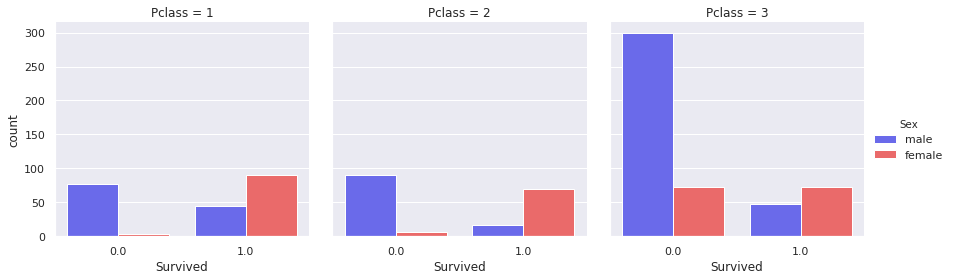

In [9]:
# countplot for 'Survived'
sns.catplot(x='Survived', hue='Sex', data=titanic, col='Pclass', kind='count', palette='seismic', height=4)

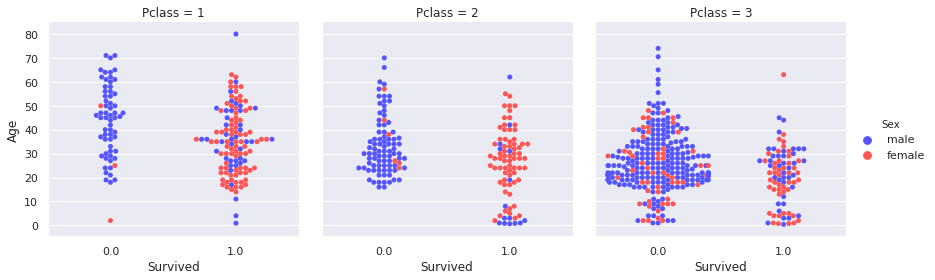

In [10]:
# swarmplot for 'Age'
sns.catplot(x='Survived', y='Age', hue='Sex', data=titanic, col='Pclass', kind='swarm', height=4, palette='seismic')

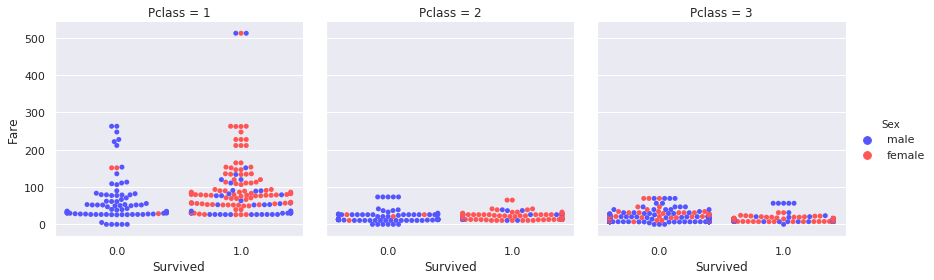

In [11]:
# swarmplot for 'Fare'
sns.catplot(x='Survived', y='Fare', hue='Sex', data=titanic, col='Pclass', kind='swarm', height=4, palette='seismic')

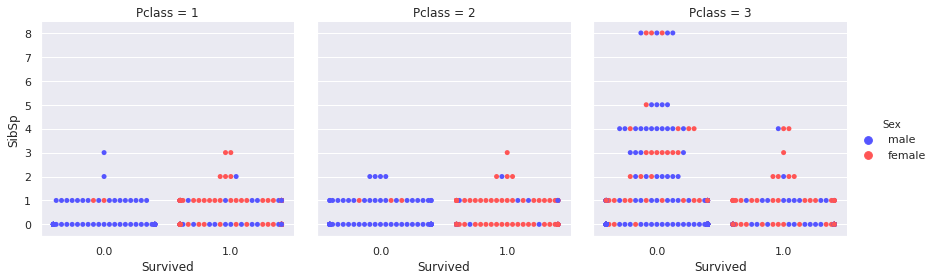

In [12]:
# swarmplot for 'SibSp'
sns.catplot(x='Survived', y='SibSp', hue='Sex', data=titanic, col='Pclass', kind='swarm', height=4, palette='seismic')

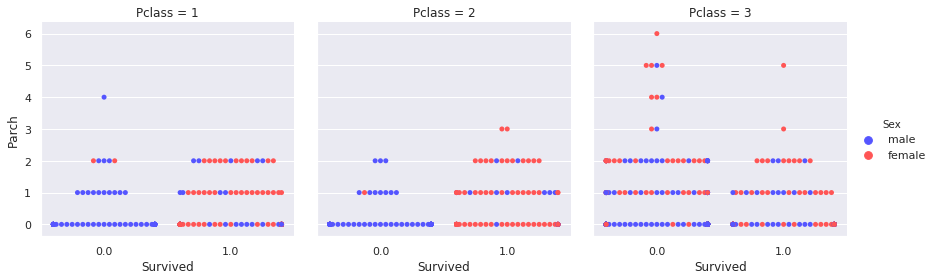

In [13]:
# swarmplot for 'Parch'
sns.catplot(x='Survived', y='Parch', hue='Sex', data=titanic, col='Pclass', kind='swarm', height=4, palette='seismic')

- For passengers under 18 years old, it seems boys survived more than girls. 
- For passengers over 18 years old, as expected females survived more than males because of "Women and Children first" code. 
- In first and second class, passengers with family on board has a higher chance of surviving than without. Higher fares had more survivors than lower fares.
- First class as expected has more survivors than other classes because first class is above deck and is in closer proximity to lifeboats. 
- Females from third class survived more than males from first class.

#### Data Preprocessing

In [14]:
# missing values
missing = titanic.isnull().sum().sort_values(ascending=False)
pct = (titanic.isnull().sum()/titanic.isnull().count()).sort_values(ascending=False)*100
total_missing = pd.concat([missing, pct], axis=1, keys=['total','percent'])
total_missing[total_missing['total']>0]

,total,percent
Cabin,1014,77.463713
Survived,418,31.932773
Age,263,20.091673
Embarked,2,0.152788
Fare,1,0.076394


- missing data from 'Survived' is for model prediction.

In [15]:
# 'Fare' NaN value
titanic[titanic['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [16]:
# stats summary of 'Fare with 'Pclass and Embarked' groupby
titanic.groupby(['Pclass', 'Embarked'])['Fare'].describe()

count        mean    ...           75%       max
Pclass Embarked                       ...                        
1      C         141.0  106.845330    ...     134.50000  512.3292
       Q           3.0   90.000000    ...      90.00000   90.0000
       S         177.0   72.148094    ...      83.47500  263.0000
2      C          28.0   23.300593    ...      31.80415   41.5792
       Q           7.0   11.735114    ...      12.35000   12.3500
       S         242.0   21.206921    ...      26.00000   73.5000
3      C         101.0   11.021624    ...      14.45830   22.3583
       Q         113.0   10.390820    ...       7.87920   29.1250
       S         494.0   14.435422    ...      15.90000   69.5500

[9 rows x 8 columns]

In [17]:
# replace with median fare from 'Pclass' 3
titanic.iloc[1043,9] = 8.05

In [18]:
# 'Embarked' NaN value
titanic[titanic['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [19]:
# replace with 'C' as passengers' fare is closest to first class median price from 'Embarked' C
titanic.iloc[61,11] = 'C'
titanic.iloc[829, 11] = 'C'

In [20]:
# deeper look at 'Age' NaN values
#titanic[titanic['Age'].isnull()].sort_values(by='Name', ascending=True)

- some passengers have $0.00 fare.
- some passengers have same ticket.
- some passengers have same surname but with different ticket.

In [21]:
# deeper look at $0.00 fare
titanic[titanic['Fare'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0.0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0.0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1.0,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0.0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0.0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0.0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0.0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0.0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0.0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


- Passengers with the ticket LINE are crew.
- The rest all had a working relationship with the Titanic.

In [22]:
# median age for passengers with fare $0.00
work_median_age = titanic[(titanic['Fare'] == 0) & (titanic['Ticket'] != 'LINE')]['Age'].median()
work_median_age

39.5

In [23]:
# function to replace 'Age' NaN values for passengers with $0.00 fare
def workers_age(col):
    Age = col[0]
    Fare = col[1]
    if pd.isnull(Age):
        if Fare == 0:
            return work_median_age
    else:
        return Age

In [24]:
# apply function 
titanic['Age'] = titanic[['Age', 'Fare']].apply(workers_age, axis=1)

In [25]:
# to replace 'Age' NaN value for the remaining passengers, need to extract social class title from 'Name'
titanic['Title'] = titanic['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [26]:
# new 'Title' column
titanic['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Major             2
Mlle              2
Jonkheer          1
Don               1
Mme               1
Sir               1
Lady              1
Capt              1
Dona              1
the Countess      1
Name: Title, dtype: int64

- A mix of English, French, royalty, and rare social titles aboard the Titanic

In [27]:
# title dictionary to combine similar and rare titles together
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

In [28]:
# map title dictionary
titanic['Title'] = titanic['Title'].map(Title_Dictionary)

In [29]:
# groupby 'Pclass, Sex, and Title' to get age stats summary
titanic.groupby(['Pclass', 'Sex', 'Title'])['Age'].describe()

count       mean        std  ...    50%    75%   max
Pclass Sex    Title                                 ...                    
1      female Miss      61.0  30.131148  11.528914  ...   30.0  36.00  63.0
              Mrs       68.0  42.926471  14.122403  ...   45.0  53.25  76.0
              Officer    1.0  49.000000        NaN  ...   49.0  49.00  49.0
              Royalty    3.0  40.000000   7.549834  ...   39.0  43.50  48.0
       male   Master     5.0   6.984000   4.974061  ...    6.0  11.00  13.0
              Mr       135.0  41.407407  13.340292  ...   41.0  50.00  80.0
              Officer   11.0  51.090909   9.689732  ...   52.0  54.50  70.0
              Royalty    3.0  42.333333   5.859465  ...   40.0  44.50  49.0
2      female Miss      48.0  20.717083  12.207963  ...   20.0  28.50  50.0
              Mrs       55.0  33.418182  10.422005  ...   30.0  40.50  60.0
       male   Master    11.0   2.757273   2.723942  ...    2.0   3.00   8.0
              Mr       143.0  32.646853  11.697603  ...   30.0  39.50  70.0
              Officer   10.0  40.700000  12.927576  ...   41.5  53.25  57.0
3      female Miss     103.0  17.360874   9.935434  ...   18.0  23.00  45.0
              Mrs       49.0  32.326531  10.194745  ...   31.0  39.00  63.0
       male   Master    37.0   6.090000   4.152566  ...    6.0   9.00  14.5
              Mr       312.0  28.318910   9.907858  ...   26.0  33.00  74.0

[17 rows x 8 columns]

- The title 'Masters' only represent boys under 15 years old.
- Adults are age 15 and above.

In [30]:
# deeper look at under 18 passengers
u_18 = titanic[titanic['Age']<=18]
#u_18

In [31]:
# 'Master' median age
master_median_age = u_18[u_18['Title'] == 'Master']['Age'].median()

In [32]:
# function to replace 'Master' median age
def master_age(col):
    Age = col[0]
    Title = col[1]
    if pd.isnull(Age):
        if Title == 'Master':
            return master_median_age
    else:
        return Age

In [33]:
# apply 'master_age' function
titanic['Age'] = titanic[['Age', 'Title']].apply(master_age, axis=1)

In [34]:
# deeper look at under 18 female passengers
#u_18[u_18['Sex'] == 'female']

- The title 'Miss' is to classify all single female passenger regardless of age. To create a group similar to 'Master' title, will classify girls under 15 as 'Missy' title.
- By creating another 'Title' group, a more accurate age of passengers can be calculated to see if correlation has improved.
- Filling in median age for female passengers should be more accurate based on title.


In [35]:
# function to rename 'Miss' to 'Missy' to represent girls under 15
def girls_title(df):
    if df['Title'] == 'Miss':
        if df['Age'] < 15:
            return 'Missy'
        else:
            return df['Title']
    else:
        return df['Title']

In [36]:
# apply function 'girls_title'
titanic['Title'] = titanic[['Title', 'Age']].apply(girls_title, axis=1)

# groupby 'Pclass, Sex, and Title' updated stats summary for 'Age'
median_pclass_age = titanic.groupby(['Pclass', 'Sex', 'Title'])
#median_pclass_age['Age'].describe()

In [37]:
# lambda function to fill in remaining NaN values based on median age from 'median_pclass_age'
titanic['Age'] = median_pclass_age['Age'].apply(lambda x: x.fillna(x.median()))

In [38]:
# fill in 'Cabin' NaN values with 'U' for unknown
titanic['Cabin'] = titanic['Cabin'].fillna('U')

In [39]:
# verify missing values, only 'Survived' should have missing values
titanic.isnull().sum().sort_values(ascending=False)

Survived       418
Title            0
Embarked         0
Cabin            0
Fare             0
Ticket           0
Parch            0
SibSp            0
Age              0
Sex              0
Name             0
Pclass           0
PassengerId      0
dtype: int64

#### Data Cleaning and Feature Engineering

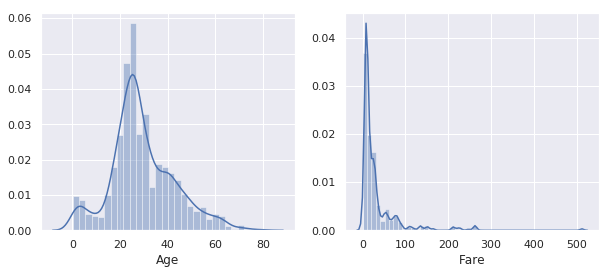

In [40]:
# plots for continuous 'Age' and 'Fare'
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.distplot(titanic['Age'], ax=axes[0])
sns.distplot(titanic['Fare'], ax=axes[1])

- 'Age' is slightly positive skewed, will leave as is, however 'Fare' is positively skewed and not normal distribution. 
- 'Fare' will be unskew and normalize if to use in prediction.
- To unskew and normalize 'Fare', first find passengers that are traveling on same ticket, passengers that travel in a group their 'Fare' represents the total price paid for the ticket. 

In [41]:
# groupby ticket and count passengers traveling on same ticket
titanic['Same_Ticket'] = titanic.groupby('Ticket')['PassengerId'].transform('count')

# count the number of passengers traveling in a group
titanic[titanic['Same_Ticket'] >1]['Same_Ticket'].count()

596

- There 596 passengers that are traveling in groups.
- To find individual ticket price, divide 'Fare' by 'Same_Ticket'

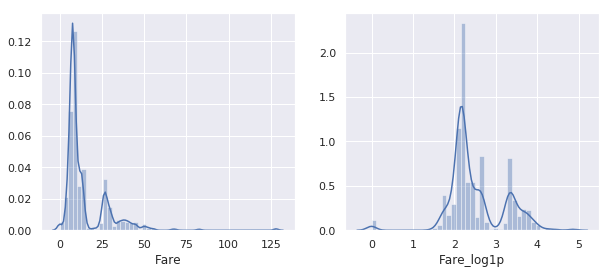

In [42]:
# divide 'Fare' by 'Same_Ticket'
titanic['Fare'] = titanic['Fare'] / titanic['Same_Ticket']

# np.log1p 'Fare' to normalize
titanic['Fare_log1p'] = np.log1p(titanic['Fare'])

# updated distribution plots for fare
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.distplot(titanic['Fare'], ax=axes[0])
sns.distplot(titanic['Fare_log1p'], ax=axes[1])

In [43]:
# new 'Family' to represent passengers traveling with family or not
titanic['Family'] = titanic['SibSp'] + titanic['Parch']

# new 'Family_size' to represent total number of family members, if equal 1, passenger is traveling alone or with non family group
titanic['Family_size'] = titanic['Parch'] + titanic['SibSp'] + 1
#titanic['Family_size'].value_counts()

In [44]:
# deeper look at passengers with no family
no_family = titanic[(titanic['SibSp'] == 0) & (titanic['Parch'] ==0)]

# groupby to count number of passengers with same ticket and no family members
no_family['Friends_group'] = no_family.groupby('Ticket')['PassengerId'].transform('count')

# add 'Family' and 'Friends_group' to get group size
no_family['Group_size'] = no_family['Family'] + no_family['Friends_group']

In [45]:
# update titanic dataset with 'no_family'
nf = no_family[['PassengerId', 'Group_size']]

# create 'Group_size' from 'Family_size'
titanic['Group_size'] = titanic['Family_size']

# update titanic with 'no_family' data
new_df = titanic[['PassengerId', 'Group_size']].set_index('PassengerId')
new_df.update(no_family.set_index('PassengerId'))
titanic['Group_size'] = new_df.values
titanic['Group_size'] = titanic['Group_size'].astype(int)

In [46]:
# clean 'Ticket' by extracting letters and converting digit only tickets to 'xxx'
tickets = titanic['Ticket'].apply(lambda t: t.split('.')[0].split()[0].replace('/','').replace('.',''))

# convert to list
tickets = tickets.tolist()

In [47]:
# function to convert digit only tickets to 'xxx'
def ticket_digits(t):
    v = []
    for i in t:
        if i.isnumeric():
            i == 'xxx'
            v.append(i)
        else:
            v.append(i)
    return v

In [48]:
# call 'ticket_digits' function
tickets = ticket_digits(tickets)

# assign to titanic dataset
titanic['Ticks'] = pd.DataFrame(tickets)

# number of clean tickets 
ticket_count = dict(titanic['Ticks'].value_counts())
titanic['Ticket_count'] = titanic['Ticks'].apply(lambda t: ticket_count[t])

In [49]:
# extract surnames from 'Name'
titanic['Surname'] = titanic['Name'].apply(lambda x: x.split(',')[0].strip())

# create 'SurnameId' to group same surname
titanic['SurnameId'] = titanic.groupby('Surname').ngroup().add(1)

# groupby 'Ticket' and 'Surname' to represent groups with same ticket or family
titanic['GroupId'] = titanic.groupby(['Ticket', 'Surname']).ngroup().add(1)


- Some passengers incorrectly grouped, such as same family but bought different ticket.

In [50]:
# extract 'Cabin' letters to group
titanic['Cabin_group'] = titanic['Cabin'].apply(lambda x: x[0])

#### Calculating group survival confidence 

In [51]:
# separate dataframe to calculate confidence
group_survival = titanic[['Pclass', 'Survived', 'Surname', 'SurnameId', 'Group_size', 'GroupId', 'Family_size', 'Ticket']]

# sum the number of survivors in a group
group_survival['group_survived'] = group_survival.groupby('GroupId')['Survived'].transform('sum')

# adjust the number of survivors in a group
group_survival['adj_survived'] = group_survival['group_survived'] - group_survival['Survived'].apply(lambda x: 1 if x == 1 else 0)

# sum the number of dead in a group
group_survival['group_dead'] = group_survival.groupby('GroupId')['Survived'].transform('count') - group_survival.groupby('GroupId')['Survived'].transform('sum')

# adjust the number of dead in a group
group_survival['adj_dead'] = group_survival['group_dead'] - group_survival['Survived'].apply(lambda x: 1 if x == 0 else 0)

# confidence of survival on single group of passengers
no_data = (group_survival['Group_size'] - group_survival['adj_survived'] - group_survival['adj_dead'])/(group_survival['Group_size'])

# calculate confidence
confidence = 1 - no_data
group_survival['confidence'] = confidence * ((1/group_survival['Group_size']) * (group_survival['adj_survived'] - group_survival['adj_dead']))

# assign back to titanic
titanic['confidence'] = group_survival['confidence']

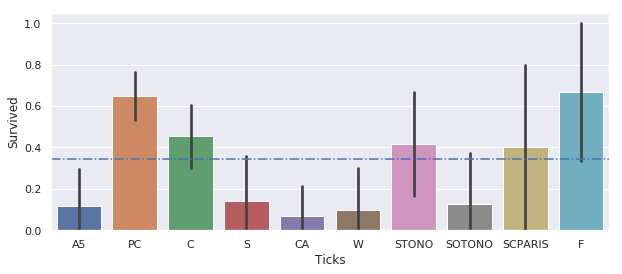

In [52]:
# plot for 'Ticks'
plt.figure(figsize=(10,4))
sns.barplot(x= 'Ticks', y='Survived', data=titanic[titanic['Ticket_count']>10])
plt.axhline(y = np.mean(titanic.groupby('Ticks')['Survived'].mean()), linestyle='-.')

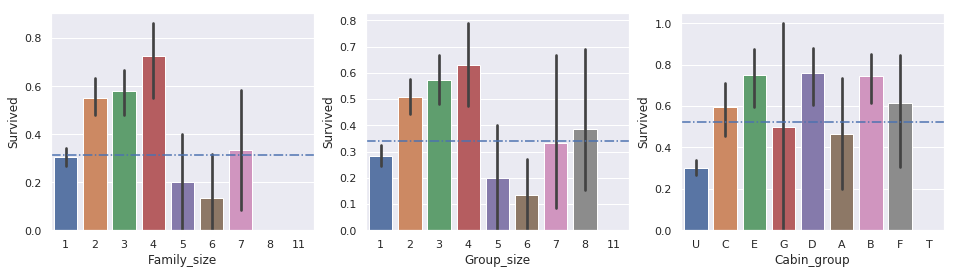

In [53]:
# plots for 'Family_size', 'Group_size', and 'Cabin_group'
fig, axes = plt.subplots(1,3, figsize=(16,4))
sns.barplot(x='Family_size', y='Survived', data=titanic, ax=axes[0])
axes[0].axhline(y=np.mean(titanic.groupby('Family_size')['Survived'].mean()), linestyle='-.')
sns.barplot(x='Group_size', y='Survived', data=titanic, ax=axes[1])
axes[1].axhline(y=np.mean(titanic.groupby('Group_size')['Survived'].mean()), linestyle='-.')
sns.barplot(x='Cabin_group', y='Survived', data=titanic, ax=axes[2])
axes[2].axhline(y=np.mean(titanic.groupby('Cabin_group')['Survived'].mean()), linestyle='-.')

In [54]:
# add column for 'Kid'
titanic['Kid'] = (titanic['Age'] < 15).astype(int)

In [55]:
# function to categorize 'Family_size'
def family_2_cat(df):
    if df <= 2:
        return 'single'
    elif (df > 2) & (df < 5):
        return 'small'
    elif df >= 5:
        return 'large'     

In [56]:
# apply function on 'Family_size'
titanic['Family_cat'] = titanic['Family_size'].apply(family_2_cat)

In [57]:
# bin 'Age' to range
pd.cut(titanic['Age'], 5).value_counts()

(16.136, 32.102]    735
(32.102, 48.068]    312
(0.0902, 16.136]    142
(48.068, 64.034]    107
(64.034, 80.0]       13
Name: Age, dtype: int64

In [58]:
# function to categorize 'Age'
def age_2_cat(df):
    if df < 15:
        return 'kid'
    elif (df >= 15) & (df <= 32):
        return 'young adult'
    elif (df > 32) & (df <= 64):
        return 'adult'
    elif (df > 64):
        return 'senior'

In [59]:
# apply function 'age_2_cat'
titanic['Age_range'] = titanic['Age'].apply(age_2_cat)

In [60]:
# bin 'Fare' to a range
titanic['Fare_range'] = pd.qcut(titanic['Fare'],3, labels=False)

In [61]:
# select best and worst survival chance from 'Ticks'
titanic['PC'] = (titanic['Ticks'] == 'PC').astype(int)
titanic['CA'] = (titanic['Ticks'] == 'CA').astype(int)

# select best and worst survival chance from 'Cabin_group'
titanic['D'] = (titanic['Cabin_group'] == 'D').astype(int)
titanic['U'] = (titanic['Cabin_group'] == 'U').astype(int)

#### Feature Selection and Modeling

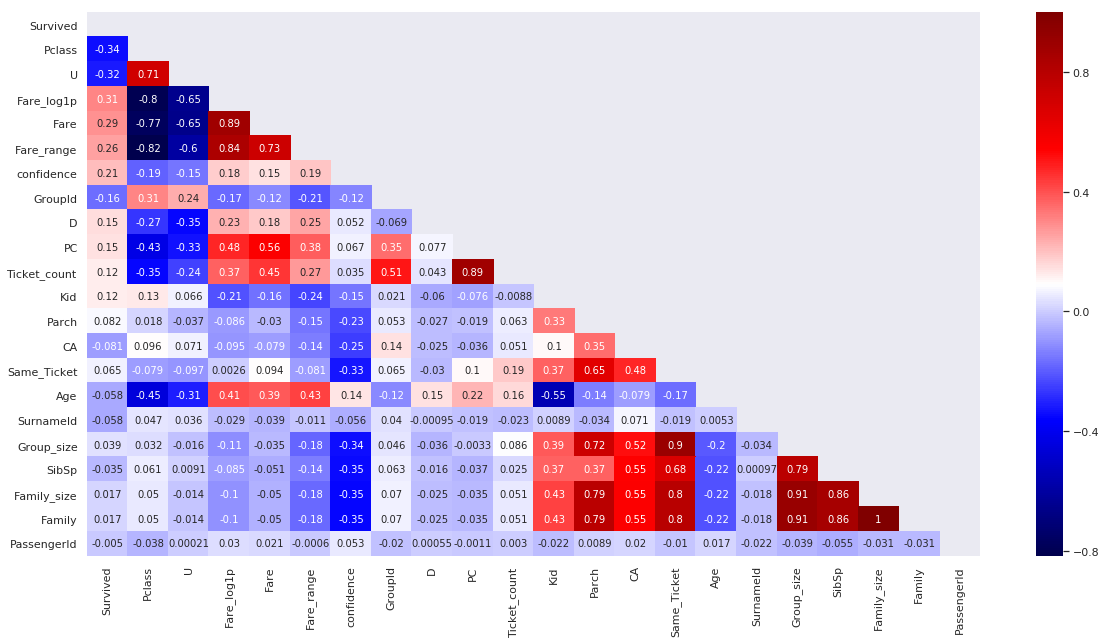

In [62]:
# Feature correlation heatmap sorted by most correlated to "Survived"
corr = titanic.corr()
idx = corr.abs().sort_values(by='Survived', ascending=False).index
train_corr_idx = titanic.loc[:, idx]
train_corr = train_corr_idx.corr()
mask = np.zeros_like(train_corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,10))
sns.heatmap(train_corr, mask=mask, annot =True, cmap = 'seismic')

In [63]:
# select 
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Title','Group_size', 'CA', 'PC','Kid','confidence', 'Fare_log1p']

titanic_full = titanic[features]

# map female to 0, male to 1
titanic_full['Sex'] = titanic_full['Sex'].map({'female': 0, 'male': 1})

# get dummy variables
titanic_feats = pd.get_dummies(titanic_full)

In [64]:
# assign to train and test set
df_train = titanic_feats[:train_idx]
df_test = titanic_feats[test_idx:]

# assign for train test split
X = df_train
y = train['Survived']
test_X = df_test

In [65]:
# import necessary modeling libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [66]:
# scale continuous data
scaler = MinMaxScaler()

# fit, tranform on X and transform on test_X
X[['Fare_log1p','Group_size']] = scaler.fit_transform(X[['Fare_log1p', 'Group_size']])
test_X[['Fare_log1p', 'Group_size']] = scaler.transform(test_X[['Fare_log1p','Group_size']])

In [67]:
# train split test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 8)

In [68]:
# models
rfc = RandomForestClassifier()
svc = SVC()
knn = KNeighborsClassifier()
gboost = GradientBoostingClassifier()
logreg = LogisticRegressionCV()

models = [rfc, svc, knn, gboost, logreg]

In [69]:
for model in models:
    print('cross validation of: {0}'.format(model.__class__))
    score = cross_val_score(model, x_train, y_train, cv= 5, scoring = 'accuracy')
    print('cv score: {0}'.format(np.mean(score)))
    print('#'*50)

cross validation of: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
cv score: 0.8200704225352112
##################################################
cross validation of: <class 'sklearn.svm.classes.SVC'>
cv score: 0.8383411580594679
##################################################
cross validation of: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
cv score: 0.8102699530516432
##################################################
cross validation of: <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
cv score: 0.8369718309859155
##################################################
cross validation of: <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
cv score: 0.8327269170579029
##################################################


In [70]:
# RFC
rfc = RandomForestClassifier(oob_score=True)

# fit
rfc.fit(x_train, y_train)

# oob_score_
print(rfc.oob_score_)

# model score
print(rfc.score(x_train,y_train))

# prediction on x_test
y_pred = rfc.predict(x_test)

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
print(confusion_matrix(y_test, y_pred))

# accuracy score
print('model accuracy: ',accuracy_score(y_test,y_pred))

# train error by RMSE
print('train error rmse: ',np.sqrt(mean_squared_error(y_train, rfc.predict(x_train))))

0.8216292134831461
0.9311797752808989
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       108
           1       0.81      0.77      0.79        71

   micro avg       0.84      0.84      0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

[[95 13]
 [16 55]]
model accuracy:  0.8379888268156425
train error rmse:  0.2623360911485515


In [71]:
# features of importance plot
feats = pd.DataFrame()
feats['feats'] = x_train.columns
feats['importance'] = rfc.feature_importances_
feats.sort_values(by='importance', ascending=True, inplace=True)
feats.set_index('feats', inplace=True)

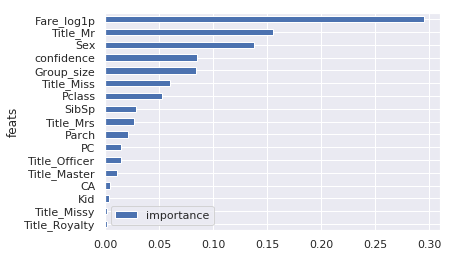

In [72]:
feats.plot(kind='barh')

In [73]:
rfc_submit = pd.DataFrame({'PassengerId': passengerId, 'Survived': rfc.predict(test_X)})
rfc_submit.to_csv('rfc_submit.csv', index=False)

- got 0.75119 score
- now to optimize model

In [74]:
# Optimize RFC parameters with GridSearchCV
model = RandomForestClassifier()

# parameters 
parameters = {
    "n_estimators": [50,100,200,300,400,500],
    "max_depth": [i for i in range(2,8)], 
    "min_samples_leaf": [i for i in range(2,8)],
    "max_leaf_nodes": [i for i in range(6,12)],
    "bootstrap": [True],
    'oob_score': [True],
    'max_features': [1,2,3]
}

# GridSearchCV (kaggle notebook reason will comment out)
#grid = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', n_jobs=-1, verbose=1, cv=5)

In [75]:
# fit x_train, y_train, for 
# grid.fit(x_train,y_train)

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 37.6min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf='deprecated', min_samples_split=2,
            min_weight_fraction_leaf='deprecated', n_estimators='warn',
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200, 300, 400, 500], 'max_depth': [2, 3, 4, 5, 6, 7], 'min_samples_leaf': [2, 3, 4, 5, 6, 7], 'max_leaf_nodes': [6, 7, 8, 9, 10, 11], 'bootstrap': [True], 'oob_score': [True], 'max_features': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [81]:
# print('best estimator: ', grid.best_estimator_)
# print('best params: ', grid.best_params_)

best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=3, max_leaf_nodes=7,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf='deprecated', n_estimators=50,
            n_jobs=None, oob_score=True, random_state=None, verbose=0,
            warm_start=False)
best params:  {'bootstrap': True, 'max_depth': 6, 'max_features': 3, 'max_leaf_nodes': 7, 'min_samples_leaf': 2, 'n_estimators': 50, 'oob_score': True}


In [79]:
best_estimator = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=3, max_leaf_nodes=7,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf='deprecated', n_estimators=50,
            n_jobs=None, oob_score=True, random_state=None, verbose=0,
            warm_start=False)

best_params = best params:  {'bootstrap': True, 'max_depth': 6, 'max_features': 3, 'max_leaf_nodes': 7, 'min_samples_leaf': 2, 'n_estimators': 50, 'oob_score': True}
    

In [82]:
rfc_grid = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=3, max_leaf_nodes=7,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf='deprecated', n_estimators=50,
            n_jobs=None, oob_score=True, random_state=None, verbose=0,
            warm_start=False)

In [88]:
rfc_grid.fit(x_train, y_train)
print('oob score: ', rfc_grid.oob_score_)
print('accuracy score on x_test: ',accuracy_score(y_test, rfc_grid.predict(x_test)))

oob score:  0.8441011235955056
accuracy score on x_test:  0.8044692737430168


In [87]:
# optimized RFC prediction
grid_prediction = pd.DataFrame({'PassengerId': passengerId, 'Survived': rfc_grid.predict(test_X)})
grid_prediction.to_csv('prediction.csv', index=False)

- Optimized RFC prediction: 0.80382
- Thoughts to improve Kaggle score: better model optimization, feature engineering on passengers traveling as groups,  married couple only,  and parents with children only.
- Thanks for taking a look!